# Logistics Optimization

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%matplotlib inline

In [3]:
import collections
import json

from IPython.display import display
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()


# Logistics Provider Environment

Every day, items are dispatched from sellers to the distribution center. Our logistics provider delivers some of items to their final destinations.

To make the problem simpler, we made following assumptions:
- We consider only one logistics provider with a single distribution center.
- Each item has a delivery cost ranging [1, 12] hours, where 12-hour is one work-day.
- If inventory is full, new items cannot be dispatched which cause penalty.

```
Warehouse (distribution center)
    .delivery_capacity (int): Delivery capacity (the number of items) at a time
    .capacity (int): Warehouse capacity (the number of items)
    .inventory (List[Item]): Items in the inventory.
    
Item
    .timestamp (int): Ordered date
    .delivery_cost (int): Delivery cost
    .delivery_type (int): Delivery due in days. E.g. next-day-delivery = 2, regular-delivery = 7.

* Environment State
    - Demand (`List[Item]`): Dynamically changing demands for item delivery 
    - Routes (`List[int]`): Dynamically changing costs (distance + traffic) for the routes between the distribution center to delivery destinations.
    - Warehouse
    
* Costs and Rewards
    - dispatching cost (`int`): Fixed (daily) cost for dispatching items from seller to distribution center
    - delivery cost (`int`): Dynamic cost for transporting items from distribution center to the final destinations. I.e. the sum of the route costs.
    - delay penalty (`int`): Penalty for the items delivered later than their delivery-date.
    - delivery price (`int`): Fixed price per delivery type (doesn't consider the size of the item for the simplicity).
    - reward: Delivery price - all the cost and penalty
    
* Agent Action (`List[int]`): Item indices to deliver

* Policy Function
    - Decide **action** based on the current **Environment State** and the policy **parameters**
    - Parameters:
        - Demand size
        - Number of items in delivery-due (<= 2 days)
        - Remaining capacity of the warehouse
        - Delivery cost threshold 
    
* Step
    - Args: Agent action
    - Returns: Environment and rewards after the agent action

* Units
    - All the costs roughly represent the time (hours) where we translate them between the reward as follows:
        - price = 1/delivery-due. e.g. 0.5 for a next-day-delivery item
        - cost per hour = 1/12 (A day = 12-hour delivery window). Both for delivery cost and delay penalty.
        - E.g. let's say we have two items to deliver (one for the next-day delivery and the other one for the regular delivery) where the final destination cost is 3/12 (i.e. 3 hours) for each. The reward without paying any penalty can be calculated as follows: 1/2 + 1/7 - (3/12 + 3/12) = 0.14
```

> TODOs:
In this first draft, the environment doesn't consider the route-optimization and use the route list (the costs between the distribution center and the destinations).
As the next step, the list should be extended to a matrix denoting the route costs (distance and traffic) between all the two points. The agent's action.item_delivery will be the ordered list where the position of the items are the delivery order.

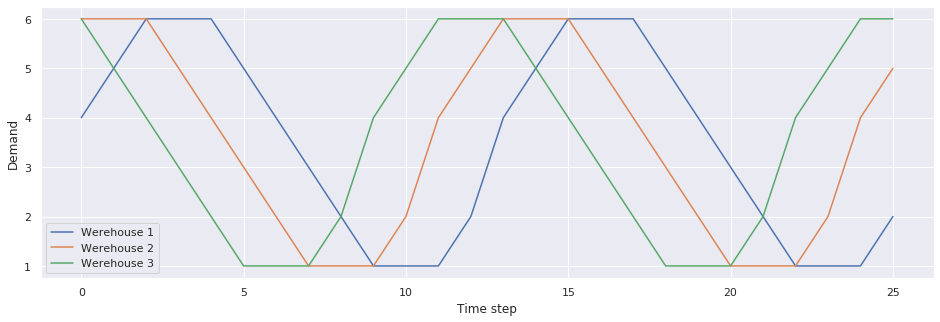

In [3]:
# visualize demand functions for warehouses
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Werehouse {i+1}' for i in range(env.warehouse_num)])

# Common Functions and Visualization

In [4]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

# Baseline Policy - (s,Q)

In [5]:
# We use (s, Q)-policy as a baseline 
# The policy is: Order your Economic Order Quantity Q, every time your inventory 
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

### Optimizing (s, Q)-policy parameters using Facebook Ax

In [ ]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'], 
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

In [ ]:
display(best_parameters)
display(best_values)

Reward: mean 7230.14, standard deviation 728.6038569757917


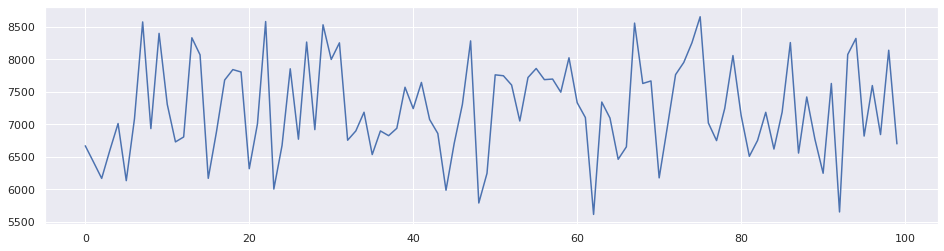

In [6]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 7264.0


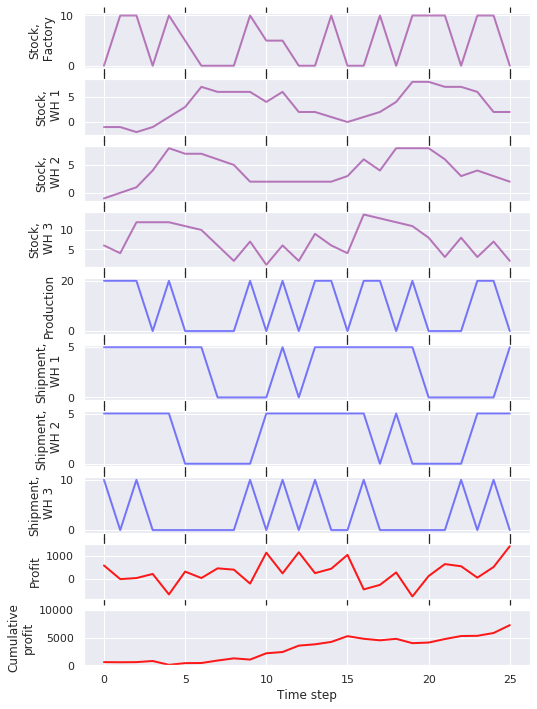

In [7]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

### Optimization of (s, Q)-policy parameters using brute force search

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [9]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}
    
ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512] 
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()

2020-03-03 00:04:13,249	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-03 00:04:13,251	INFO resource_spec.py:212 -- Starting Ray with 6.1 GiB memory available for workers and up to 3.06 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-03 00:04:13,627	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-03 00:04:15,449	WARNING

custom_metrics: {}
date: 2020-03-03_00-04-17
done: false
episode_len_mean: 25.0
episode_reward_max: -470657.2189464569
episode_reward_mean: -611079.5356833935
episode_reward_min: -819946.0391860008
episodes_this_iter: 40
episodes_total: 40
experiment_id: b95ac292b66942a79110c1d34fbed69d
hostname: jumin-surface
info:
  exploration_infos:
  - 1.0
  grad_time_ms: .nan
  learner: {}
  num_steps_sampled: 1000
  num_steps_trained: 0
  num_target_updates: 166
  opt_peak_throughput: 0.0
  opt_samples: .nan
  replay_time_ms: .nan
  sample_time_ms: 1.409
  update_time_ms: 0.002
iterations_since_restore: 1
node_ip: 192.168.99.193
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 24.833333333333332
  ram_util_percent: 62.93333333333334
pid: 12393
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.26054482359986203
  mean_inference_ms: 0.6296020168643612
  mean_processing_ms: 0.2725267267370081
time_since_restore: 1.6132488

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))